# Getting the dataset

In [1]:
from google.colab import drive 
from google.colab import files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/MyDrive/Models/Data/DIV2K_train_HR.zip /content/DIV2K_train_HR.zip

In [3]:
!cp /content/gdrive/MyDrive/Models/Data/DIV2K_train_LR_unknown_X2.zip /content/DIV2K_train_LR_unknown_X2.zip

In [4]:
!unzip /content/DIV2K_train_HR.zip

Archive:  /content/DIV2K_train_HR.zip
   creating: DIV2K_train_HR/
  inflating: DIV2K_train_HR/0103.png  
  inflating: DIV2K_train_HR/0413.png  
  inflating: DIV2K_train_HR/0031.png  
  inflating: DIV2K_train_HR/0660.png  
  inflating: DIV2K_train_HR/0126.png  
  inflating: DIV2K_train_HR/0793.png  
  inflating: DIV2K_train_HR/0764.png  
  inflating: DIV2K_train_HR/0550.png  
  inflating: DIV2K_train_HR/0437.png  
  inflating: DIV2K_train_HR/0374.png  
  inflating: DIV2K_train_HR/0755.png  
  inflating: DIV2K_train_HR/0614.png  
  inflating: DIV2K_train_HR/0646.png  
  inflating: DIV2K_train_HR/0371.png  
  inflating: DIV2K_train_HR/0312.png  
  inflating: DIV2K_train_HR/0108.png  
  inflating: DIV2K_train_HR/0556.png  
  inflating: DIV2K_train_HR/0794.png  
  inflating: DIV2K_train_HR/0722.png  
  inflating: DIV2K_train_HR/0780.png  
  inflating: DIV2K_train_HR/0555.png  
  inflating: DIV2K_train_HR/0439.png  
  inflating: DIV2K_train_HR/0396.png  
  inflating: DIV2K_train_HR/0666.png

In [5]:
!unzip /content/DIV2K_train_LR_unknown_X2.zip

Archive:  /content/DIV2K_train_LR_unknown_X2.zip
   creating: DIV2K_train_LR_unknown/X2/
  inflating: DIV2K_train_LR_unknown/X2/0261x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0229x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0188x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0711x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0187x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0198x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0770x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0694x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0001x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0414x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0123x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0067x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0538x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0178x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0587x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0357x2.png  
  inflating: DIV2K_train_LR_unknown/X2/0598x2.png  
  inflating: DIV2K_train_LR

In [6]:
!rm /content/DIV2K_train_HR.zip
!rm /content/DIV2K_train_LR_unknown_X2.zip

# Developing Generator and Discriminator

In [27]:
import keras
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Dense, BatchNormalization
import numpy as np
from PIL import Image
# import random
from typing import List, Tuple
import os
import cv2

In [13]:
hr_patches = []
lr_patches = []
PATCH_SIZE = 100
SCALING_FACTOR = 2
STRIDE = 200

In [8]:
def Generator():
  gen_input = keras.layers.Input((None, None, 3))
  gen = keras.layers.Conv2D(filters=16, kernel_size=3, strides = 1, padding="same")(gen_input)
  # TODO: try using PReLU here
  gen = keras.layers.advanced_activations.LeakyReLU()(gen)
  # gen = keras.activations.leaky_relu()(gen)
  gen_layer = gen

  for i in range(1):
    gen = keras.layers.Conv2D(filters=16, kernel_size=3, strides = 1, padding="same")(gen)
    gen = BatchNormalization()(gen)
    gen = keras.layers.advanced_activations.LeakyReLU()(gen)
    gen = keras.layers.Conv2D(filters=16, kernel_size=3, strides = 1, padding="same")(gen)
    gen = BatchNormalization()(gen)
    gen = keras.layers.advanced_activations.LeakyReLU()(gen)

  gen = keras.layers.add([gen_layer,gen])

  gen = keras.layers.Conv2D(filters=3, kernel_size=3, strides = 1, padding="same", activation = "relu")(gen)
  #TODO: implement upscaling using subpixel
  #i.e. convolution with filters = scale^2, depth to space conversion
  gen = keras.layers.Conv2D(3 * (SCALING_FACTOR ** 2), kernel_size=3, strides = 1, padding="same", activation = "relu")(gen)
  gen = tf.nn.depth_to_space(gen, 2)
  gen = keras.layers.Conv2D(filters=3, kernel_size=3, strides = 1, padding="same", activation = "relu")(gen)

  gen_model = keras.models.Model(inputs = gen_input, outputs = gen)
  return gen_model

In [9]:
def Discriminator():
  disc_input = keras.layers.Input((PATCH_SIZE*SCALING_FACTOR, PATCH_SIZE*SCALING_FACTOR, 3))
  disc = keras.layers.Conv2D(filters=4, kernel_size=3, strides = 1, padding="valid")(disc_input)
  disc = keras.layers.LeakyReLU()(disc)
  for i in range(1):
    disc = keras.layers.Conv2D(filters=4, kernel_size=3, strides = 1, padding="valid")(disc)
    disc = BatchNormalization()(disc)
    disc = keras.layers.LeakyReLU()(disc)
  disc = keras.layers.Flatten()(disc)
  disc = keras.layers.Dense(64)(disc)
  disc = keras.layers.LeakyReLU(alpha = 0.2)(disc)
  disc = keras.layers.Dense(1)(disc)
  disc = keras.layers.Activation('sigmoid')(disc)
  
  disc_model = keras.models.Model(inputs = disc_input, outputs = disc)
  return disc_model

In [46]:
def form_gan(generator: keras.models.Model, discriminator: keras.models.Model):
  discriminator.trainable = False
  gan_input = keras.layers.Input((None,None,3))
  # plot_model(generator)
  i_sr = generator(gan_input)
  discrim_output = discriminator(i_sr)
  gan = keras.models.Model(inputs=gan_input,outputs=[i_sr, discrim_output])
  return gan

In [52]:
def get_vgg_layer_activation(image):
  vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False, input_shape=(PATCH_SIZE * SCALING_FACTOR, PATCH_SIZE * SCALING_FACTOR, 3))
  vgg19.trainable = False
  vgg_model = keras.models.Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
  vgg_model.trainable = False
  return vgg_model(image)

In [48]:
def custom_vgg_loss(actual,output):
  loss = 0
  #do MSE of actual and output by using vgg layer activation
  image = get_vgg_layer_activation(actual)
  output = get_vgg_layer_activation(output)
  loss = np.square(np.subtract(image,output)).mean()
  return loss

In [49]:
PatchPairs = List[Tuple[np.ndarray]]

In [17]:
def get_patches(i_lr: np.ndarray, i_hr: np.ndarray, stride: int, patch_size: int, random_cropping: bool = False, random_patch_count = 1) -> PatchPairs:
  lr_height, lr_width = i_lr.shape[0], i_lr.shape[1]
  patches = []
  scaling_factor = int(i_hr.shape[0]/i_lr.shape[0])
  if random_cropping:
    for i in range(random_patch_count):
      j = np.random.random_integers(0, lr_height - patch_size + 1)
      k = np.random.random_integers(0, lr_width - patch_size + 1)
      i_lr_patch = i_lr[j:j+patch_size, k:k+patch_size]
      i_hr_patch = i_hr[(j*scaling_factor):(j*scaling_factor)+(patch_size*scaling_factor), (k*scaling_factor):(k*scaling_factor)+(patch_size*scaling_factor)]
      patches.append((i_lr_patch,i_hr_patch))    
  else:
    for j in range(0, lr_height - patch_size + 1, stride):
      for k in range(0, lr_width - patch_size + 1, stride):
        i_lr_patch = i_lr[j:j+patch_size, k:k+patch_size]
        i_hr_patch = i_hr[(j*scaling_factor):(j*scaling_factor)+(patch_size*scaling_factor), (k*scaling_factor):(k*scaling_factor)+(patch_size*scaling_factor)]
        patches.append((i_lr_patch,i_hr_patch))
  return patches

In [18]:
hr_image_path = '/content/DIV2K_train_HR/'
lr_image_path = '/content/DIV2K_train_LR_unknown/X2/'
list_images_hr = os.listdir(hr_image_path)
list_images_lr = os.listdir(lr_image_path)

In [19]:
i = 0
for i in range(25):

  hr_image = cv2.imread(hr_image_path + list_images_hr[i])
  lr_image = cv2.imread(lr_image_path + list_images_hr[i].split(".")[0] + "x2.png")
  
  lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)
  hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

  patches = get_patches(lr_image, hr_image, STRIDE, PATCH_SIZE)
  for patch_pair in patches:
    lr_patches.append(patch_pair[0])
    hr_patches.append(patch_pair[1])
    

In [20]:
len(lr_patches), len(hr_patches)

(410, 410)

In [53]:
def train(epochs=100,save_freq=10):
  #fetch dataset
  generator = Generator()
  discriminator = Discriminator()

  generator.compile(loss=custom_vgg_loss, optimizer=tf.keras.optimizers.Adam())
  discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())

  gan = form_gan(generator, discriminator)
  gan.compile(loss=[custom_vgg_loss,'binary_crossentropy'], optimizer=tf.keras.optimizers.Adam())

  for i in range(epochs):
    random = np.random.randint(0,100)
    current_i_lr = lr_patches[random]
    current_i_hr = hr_patches[random]
    current_i_lr = current_i_lr.reshape((1, current_i_lr.shape[0], current_i_lr.shape[1], current_i_lr.shape[2]))
    current_i_hr = current_i_hr.reshape((1, current_i_hr.shape[0], current_i_hr.shape[1], current_i_hr.shape[2]))
    current_i_sr = generator.predict(current_i_lr)
    

    discriminator.trainable = True

    d_loss_real = discriminator.fit(current_i_hr, np.array([1]))
    d_loss_fake = discriminator.fit(current_i_sr, np.array([0]))
    # print(d_loss_real.history)
    # d_loss = 0.5 * (d_loss_real + d_loss_fake)
  
    discriminator.trainable = False

    gan.fit(current_i_lr, np.array([1]))

  return (generator, discriminator)

In [ ]:
generator, discriminator = train(100, 10)

In [55]:
gan = form_gan(Generator(), Discriminator())

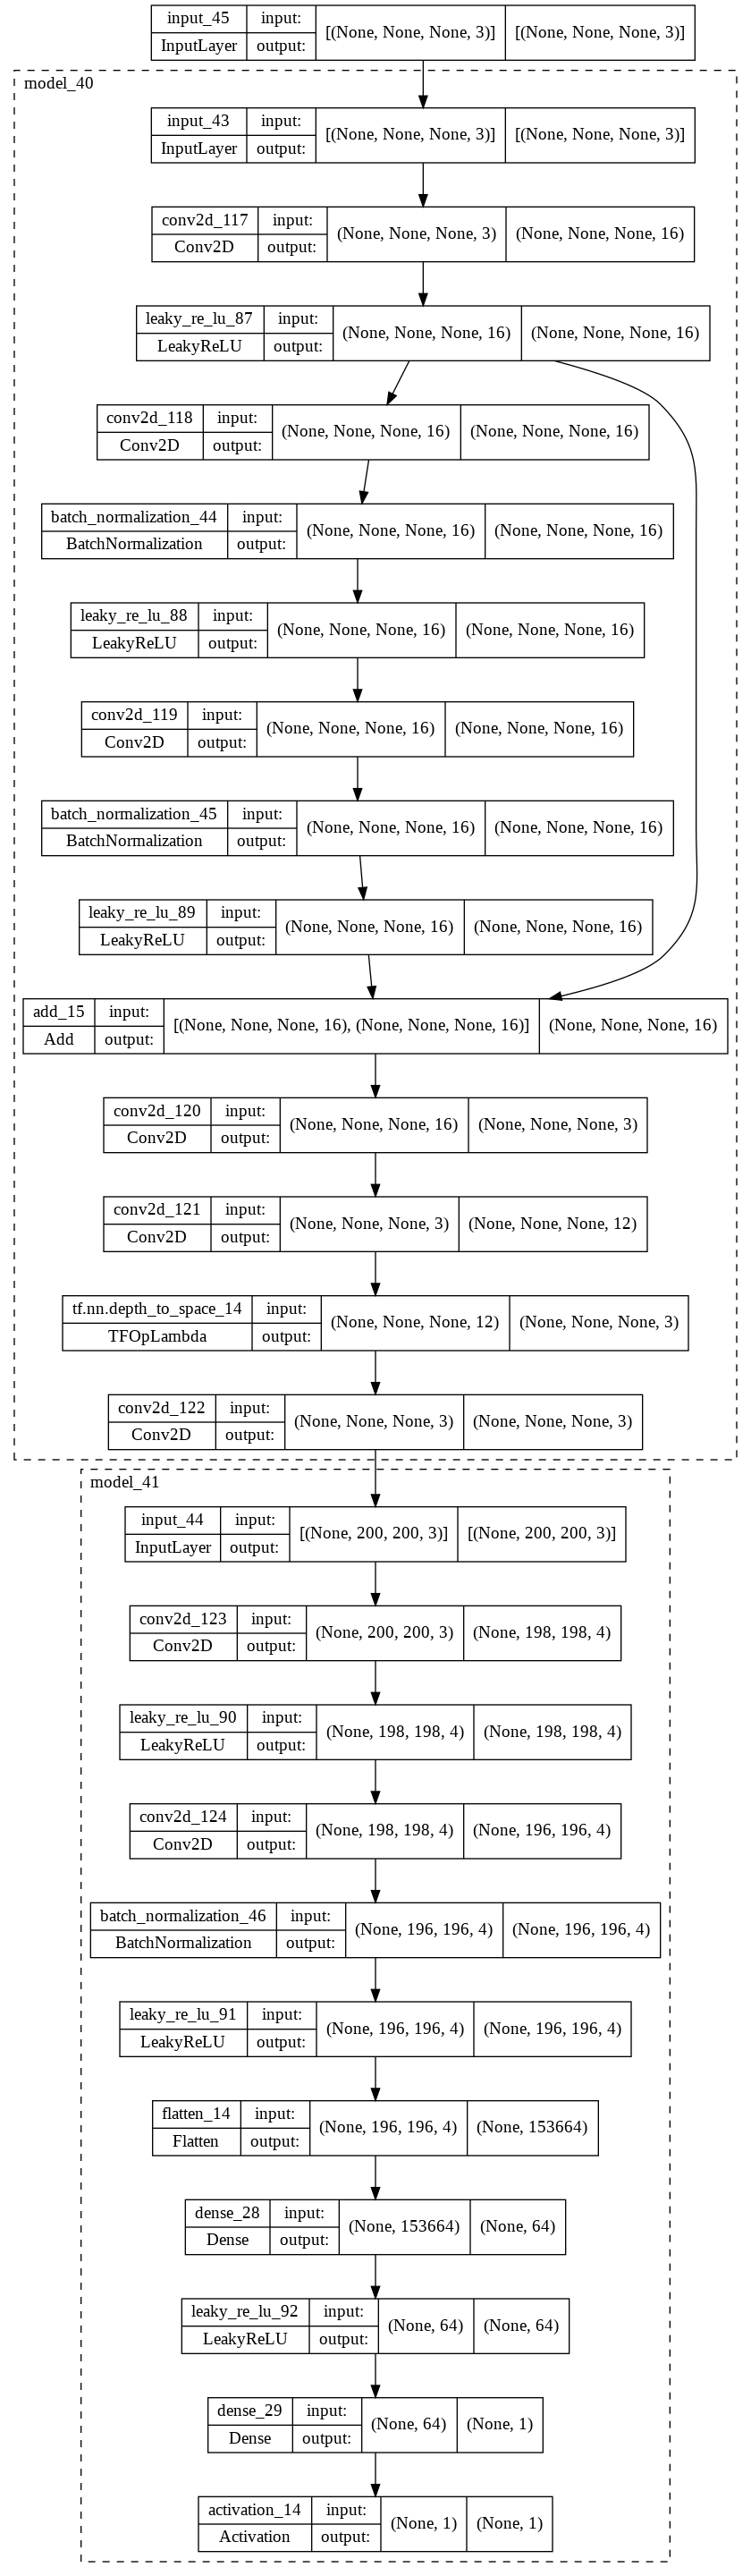

In [57]:
plot_model(gan, show_shapes=True, expand_nested=True)

In [58]:
del gan